In [ ]:
import sys
import scanpy as sc

# setting path
sys.path.append('../AMD')
import correlation_base as co
import run
import end2endPLS as pls
import matplotlib.pyplot as plt
import numpy as np
import importlib
from scipy.stats import pearsonr, kendalltau
import gseapy as gp
import pandas as pd
from gseapy import gseaplot
import warnings
from sklearn.cross_decomposition import PLSRegression
from sklearn.decomposition import PCA, SparsePCA
from scipy.linalg import pinv as pinv2
import random
import gseaAnalysis as ga
import seaborn as sns
import scipy
from sklearn.metrics import roc_auc_score
from joblib import Parallel, delayed
from sklearn.preprocessing import StandardScaler
import heatmap_r as heatmap


path_dir = '/Users/anwesha/Library/CloudStorage/OneDrive-McGillUniversity/PHD/Research/OverlapAnalysis_thor_pmi_adj/'

# Setup

In [ ]:
dpls_ros = co.CorrelationBase.read_zip_to_dict('/Users/anwesha/Library/CloudStorage/OneDrive-McGillUniversity/PHD/Research/OverlapAnalysis_thor_pmi_adj/AD/Rosmap/DEGenes/pls_500bs_5thresh_42seed.zip')

In [ ]:
dpls_kam = co.CorrelationBase.read_zip_to_dict('/Users/anwesha/Library/CloudStorage/OneDrive-McGillUniversity/PHD/Research/OverlapAnalysis_thor_pmi_adj/PD/Kam/DEGenes/pls_500bs_5thresh_42seed.zip')

In [ ]:
top_genes_ad = []
pls_ros = pd.DataFrame()
for ct, _df in dpls_ros.items():
    if ('score' not in ct) and ('_rocauc' not in ct ):
        _df['celltype'] = ct
        pls_ros = pd.concat([pls_ros, _df])
        tg = _df[(_df.loading!=0) & (_df.component==0)].sort_values('true_loading', ascending=False).groupby('component').head(5).gene
        top_genes_ad.extend(tg)

top_genes_ad = set(top_genes_ad)
len(top_genes_ad)

26

In [ ]:
ct_map_kam = {'Oligodendrocyte': 'Oli',
            'Excitatory neuron': 'Ex',
            'Inhibitory neuron': 'In',
            'Astrocyte': 'Ast',
            'Endothelial': 'End',
            'Microglia': 'Mic',
            'Macrophage': 'Macro',
            'SOX6': 'Sox6',
            'CALB1': 'Calb1',
            'Ependyma': 'Epen',
            'OPC': 'Opc'}

In [ ]:
top_genes_pd = []
pls_kam = pd.DataFrame()
for ct, _df in dpls_kam.items():
    if ('score' not in ct) and ('_rocauc' not in ct ):
        _df['celltype'] = ct_map_kam[ct]
        pls_kam = pd.concat([pls_kam, _df])
        tg = _df[(_df.loading!=0) & (_df.component==0)].sort_values('true_loading', ascending=False).groupby('component').head(5).gene
        top_genes_pd.extend(tg)

top_genes_pd = set(top_genes_pd)
len(top_genes_pd)

30

In [ ]:
pls_kam['cell_comp'] = pls_kam['celltype'] + '_' + (pls_kam['component']+1).astype('str')
pls_ros['cell_comp'] = pls_ros['celltype'] + '_' + (pls_ros['component']+1).astype('str')

In [ ]:
pls_kam[pls_kam.loading!=0].gene.unique()

array(['SEZ6L', 'KCNJ6', 'CADPS2', ..., 'ISG20L2', 'C5orf30', 'ZUFSP'],
      dtype=object)

In [ ]:
pls_merge = pd.concat([pls_kam.assign(disease='PD'), pls_ros.assign(disease='AD')])

In [ ]:
_df = pls_merge[pls_merge.loading!=0]
_df[(_df.cell_comp=='Opc_1') & (_df.disease=='AD')].gene.unique().shape

(12,)

In [ ]:
pls_kam['bs_loading'] = pls_kam.loading.map(lambda x: 0 if x==0 else 1)
pls_ros['bs_loading'] = pls_ros.loading.map(lambda x: 0 if x==0 else 1)

In [ ]:
fp_compre = '/Users/anwesha/Library/CloudStorage/OneDrive-McGillUniversity/PHD/Requirements and Formalities/Comprehensive exam/Figures/'
# f.savefig(fp_compre+'significant_gene_counts_vertical.png', dpi = 300)

# Plots

## Top gene fraction

/opt/anaconda3/envs/scrnaseq/lib/python3.10/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/anaconda3/envs/scrnaseq/lib/python3.10/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/anaconda3/envs/scrnaseq/lib/python3.10/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/anaconda3/envs/scrnaseq

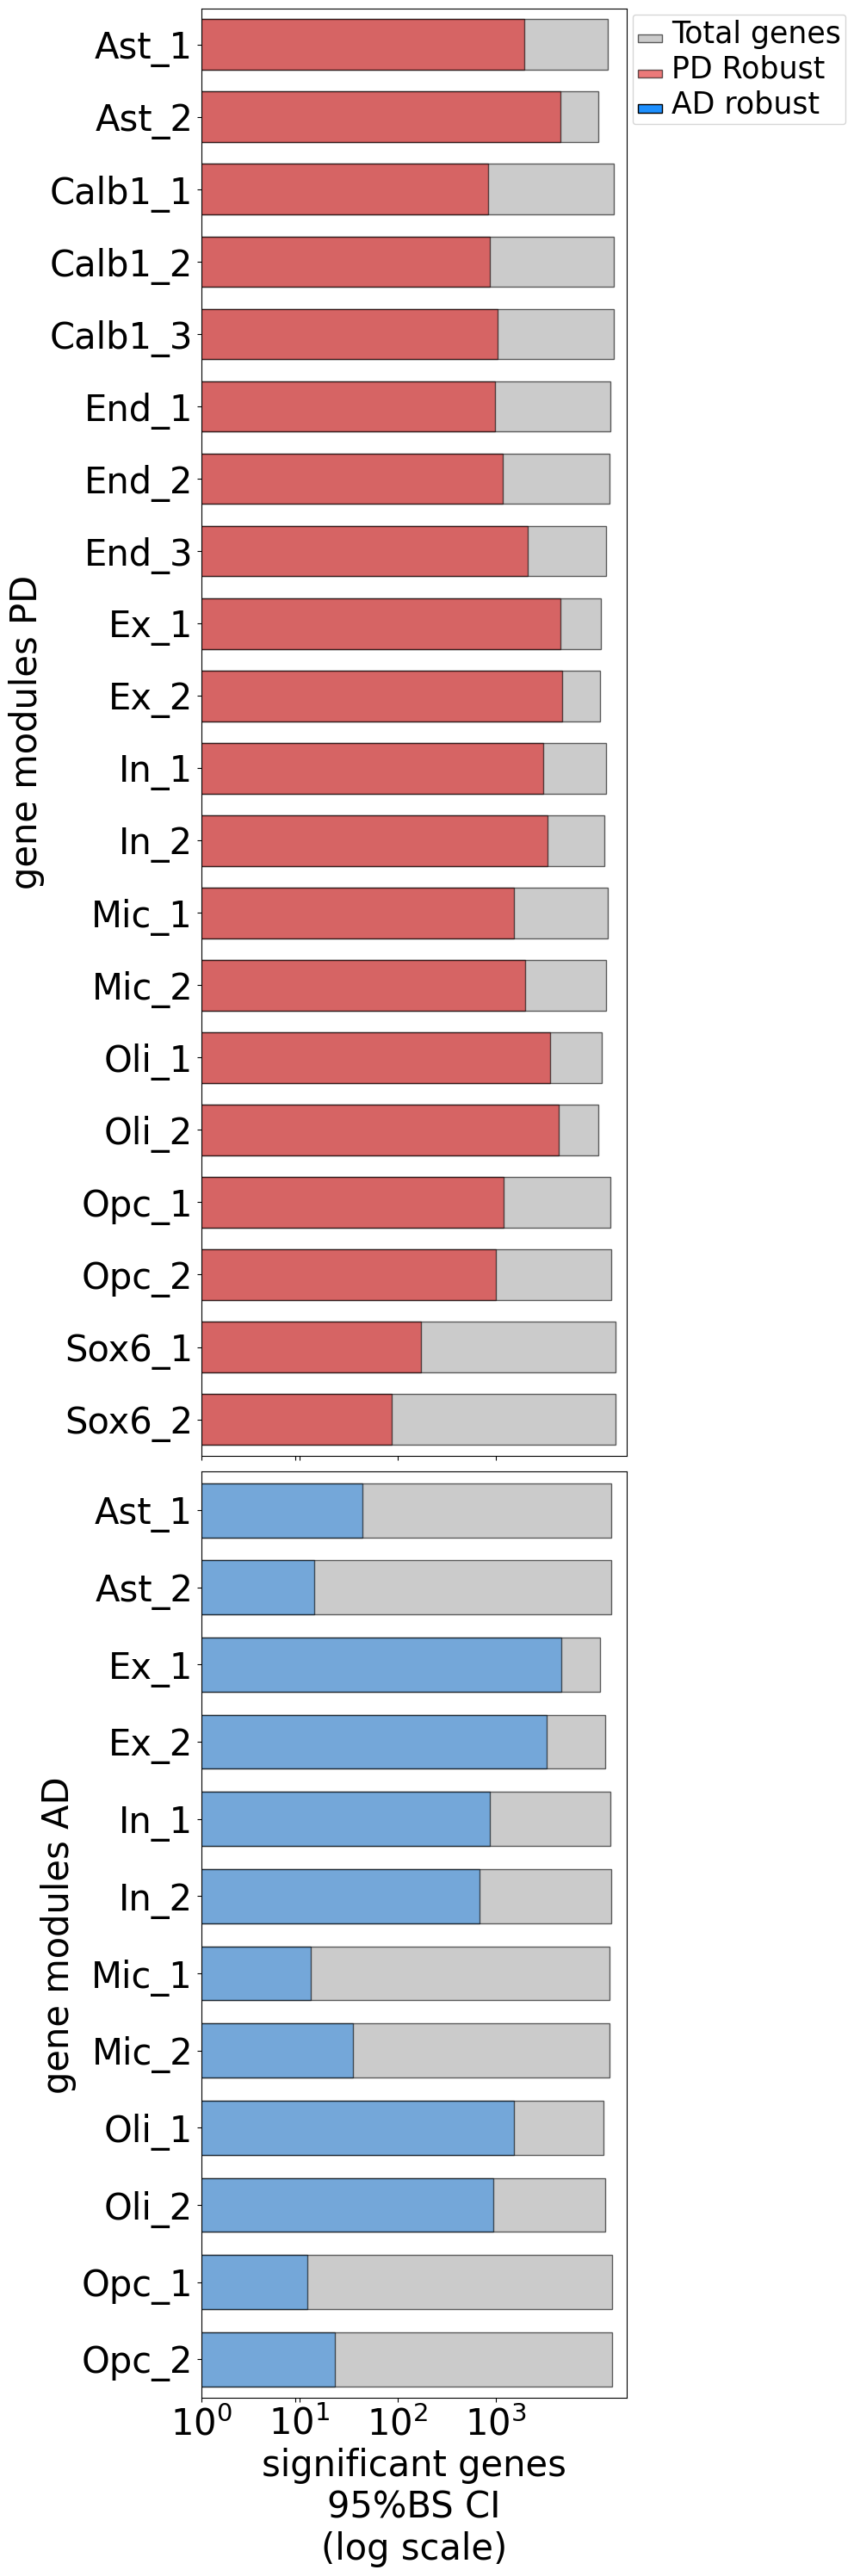

In [ ]:
f, axs= plt.subplots(2, 1, figsize=(10,30), sharex=True, height_ratios=[pls_kam.cell_comp.unique().shape[0], pls_ros.cell_comp.unique().shape[0]])
ax = axs[0]
fs = 30

width = 0.7
color_pd = 'red'
color_ad = 'dodgerblue'
nullcolor = 'darkgray'
sns.countplot(pls_kam.sort_values('cell_comp').drop(['Macrophage', 'Ependyma']), y='cell_comp', hue='bs_loading', ax = ax, width=width, palette = [nullcolor, color_pd], alpha=0.6, dodge=False, edgecolor='black')
ax.set_ylabel('gene modules PD', fontsize=fs)
ax.set_xlabel('gene set size (log scale)', fontsize=fs)
ax.tick_params(labelsize=fs)

def add_patch(legend):
    from matplotlib.patches import Patch
    ax = legend.axes

    handles, labels = ax.get_legend_handles_labels()
    handles.append(Patch(facecolor=color_ad, edgecolor='black'))
    # labels.append("AD Robust genes")
    labels=['Total genes', 'PD Robust', 'AD robust']

    legend._legend_box = None
    legend._init_legend_box(handles, labels)
    legend._set_loc(legend._loc)
    legend.set_title(legend.get_title().get_text())

# ax.legend(labels=['Total genes', 'PD robust genes'], title='BS genes')
lgd = ax.legend()
lgd.set_title('BS genes')
add_patch(lgd)


sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.setp(ax.get_legend().get_texts(), fontsize=fs-5) # for legend text
_ = plt.setp(ax.get_legend().get_title(), fontsize=fs-5)

ax1 = axs[1]
# sns.countplot(pls_ros.sort_values('cell_comp').drop(pls_ros[pls_ros.celltype.isin(['End', 'Per'])].index), y='cell_comp', hue = 'bs_loading', palette = [color, 'grey'], ax = ax1, width=width, alpha=0.6)
sns.countplot(pls_ros.sort_values('cell_comp').drop(['End', 'Per']), y='cell_comp', hue = 'bs_loading', palette = [nullcolor, color_ad], width=width, alpha=0.6, dodge=False, ax = ax1, edgecolor='black')

# sns.countplot(pls_kam[pls_kam.loading!=0].sort_values('cell_comp'), y='cell_comp', hue='celltype', palette='spring', ax = ax1, width=0.9)
ax1.set_ylabel('gene modules AD', fontsize=fs)
ax1.set_xlabel('significant genes\n95%BS CI\n(log scale)', fontsize=fs)
ax1.tick_params(labelsize=fs)
ax1.legend([],[], frameon=False)
# sns.move_legend(ax1, "upper left", bbox_to_anchor=(1, 1))
# plt.setp(ax1.get_legend().get_texts(), fontsize=fs) # for legend text
# _ = plt.setp(ax1.get_legend().get_title(), fontsize=fs)

ax1.set_xscale('log')
ax1.set_xticks([1, 10, 100, 1000, 10^3])
# ax1.get_xaxis().set_major_formatter(plt.ScalarFormatter())
f.tight_layout(pad=1)
# plt.xscale('log')


In [ ]:
top_genes = list(top_genes_ad.union(top_genes_pd))
len(top_genes)

56

In [ ]:
pls_tg_kam = pls_kam[pls_kam.gene.isin(top_genes)].copy()
pls_tg_kam['cell_comp'] = pls_tg_kam['celltype'] + '_' + (pls_tg_kam['component'].values +1).astype(str)
pls_tg_kam.loc[pls_tg_kam.loading!=0, 'loading'] = pls_tg_kam.loc[pls_tg_kam.loading!=0, 'true_loading']
pls_tg_ros = pls_ros[pls_ros.gene.isin(top_genes)].copy()
pls_tg_ros['cell_comp'] = pls_tg_ros['celltype'] + '_' + (pls_tg_ros['component'].values +1).astype(str)
pls_tg_ros.loc[pls_tg_ros.loading!=0, 'loading'] = pls_tg_ros.loc[pls_tg_ros.loading!=0, 'true_loading']

In [ ]:
merged_pls = pd.concat([
    pls_tg_ros.pivot_table(index='cell_comp', columns='gene', values='loading').assign(disease='AD').set_index('disease', append=True),
    pls_tg_kam.pivot_table(index='cell_comp', columns='gene', values='loading').assign(disease='PD').set_index('disease', append=True),
    ])
merged_pls.head()

,gene,ABHD3,ALDOA,APOD,APOE,ATP8A2,BAG3,CADPS,CALM1,CELF4,CNTNAP2,...,SERPINH1,SEZ6L,SH3BGR,SLC26A3,SNRPN,SNX31,SPP1,UBB,UTY,ZFP36L1
cell_comp,disease,,,,,,,,,,,,,,,,,,,,,
Ast_1,AD,0.0,0.000000,0.000000,-0.049248,0.0,0.0,0.0,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.07035,0.0,0.0,0.0,0.000000,0.000000,0.058111
Ast_2,AD,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.000000,0.000000,0.000000
End_1,AD,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.00000,NaN,0.0,0.0,0.000000,0.000000,0.000000
End_2,AD,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.00000,NaN,0.0,0.0,0.000000,0.000000,0.000000
Ex_1,AD,0.0,-0.033268,-0.012771,0.000000,0.0,0.0,0.0,-0.025097,0.0,0.041513,...,0.0,0.0,0.0,0.05675,0.0,0.0,0.0,-0.034704,-0.014979,0.000000


## Correlation

In [ ]:
pal = 'BrBG'
palette = sns.color_palette(pal, 128, desat=0.7)
facecolor = palette[len(palette)//2]

In [ ]:
fp = '/Users/anwesha/Library/CloudStorage/OneDrive-McGillUniversity/PHD/Research/NeuroOverlap/April_29/'

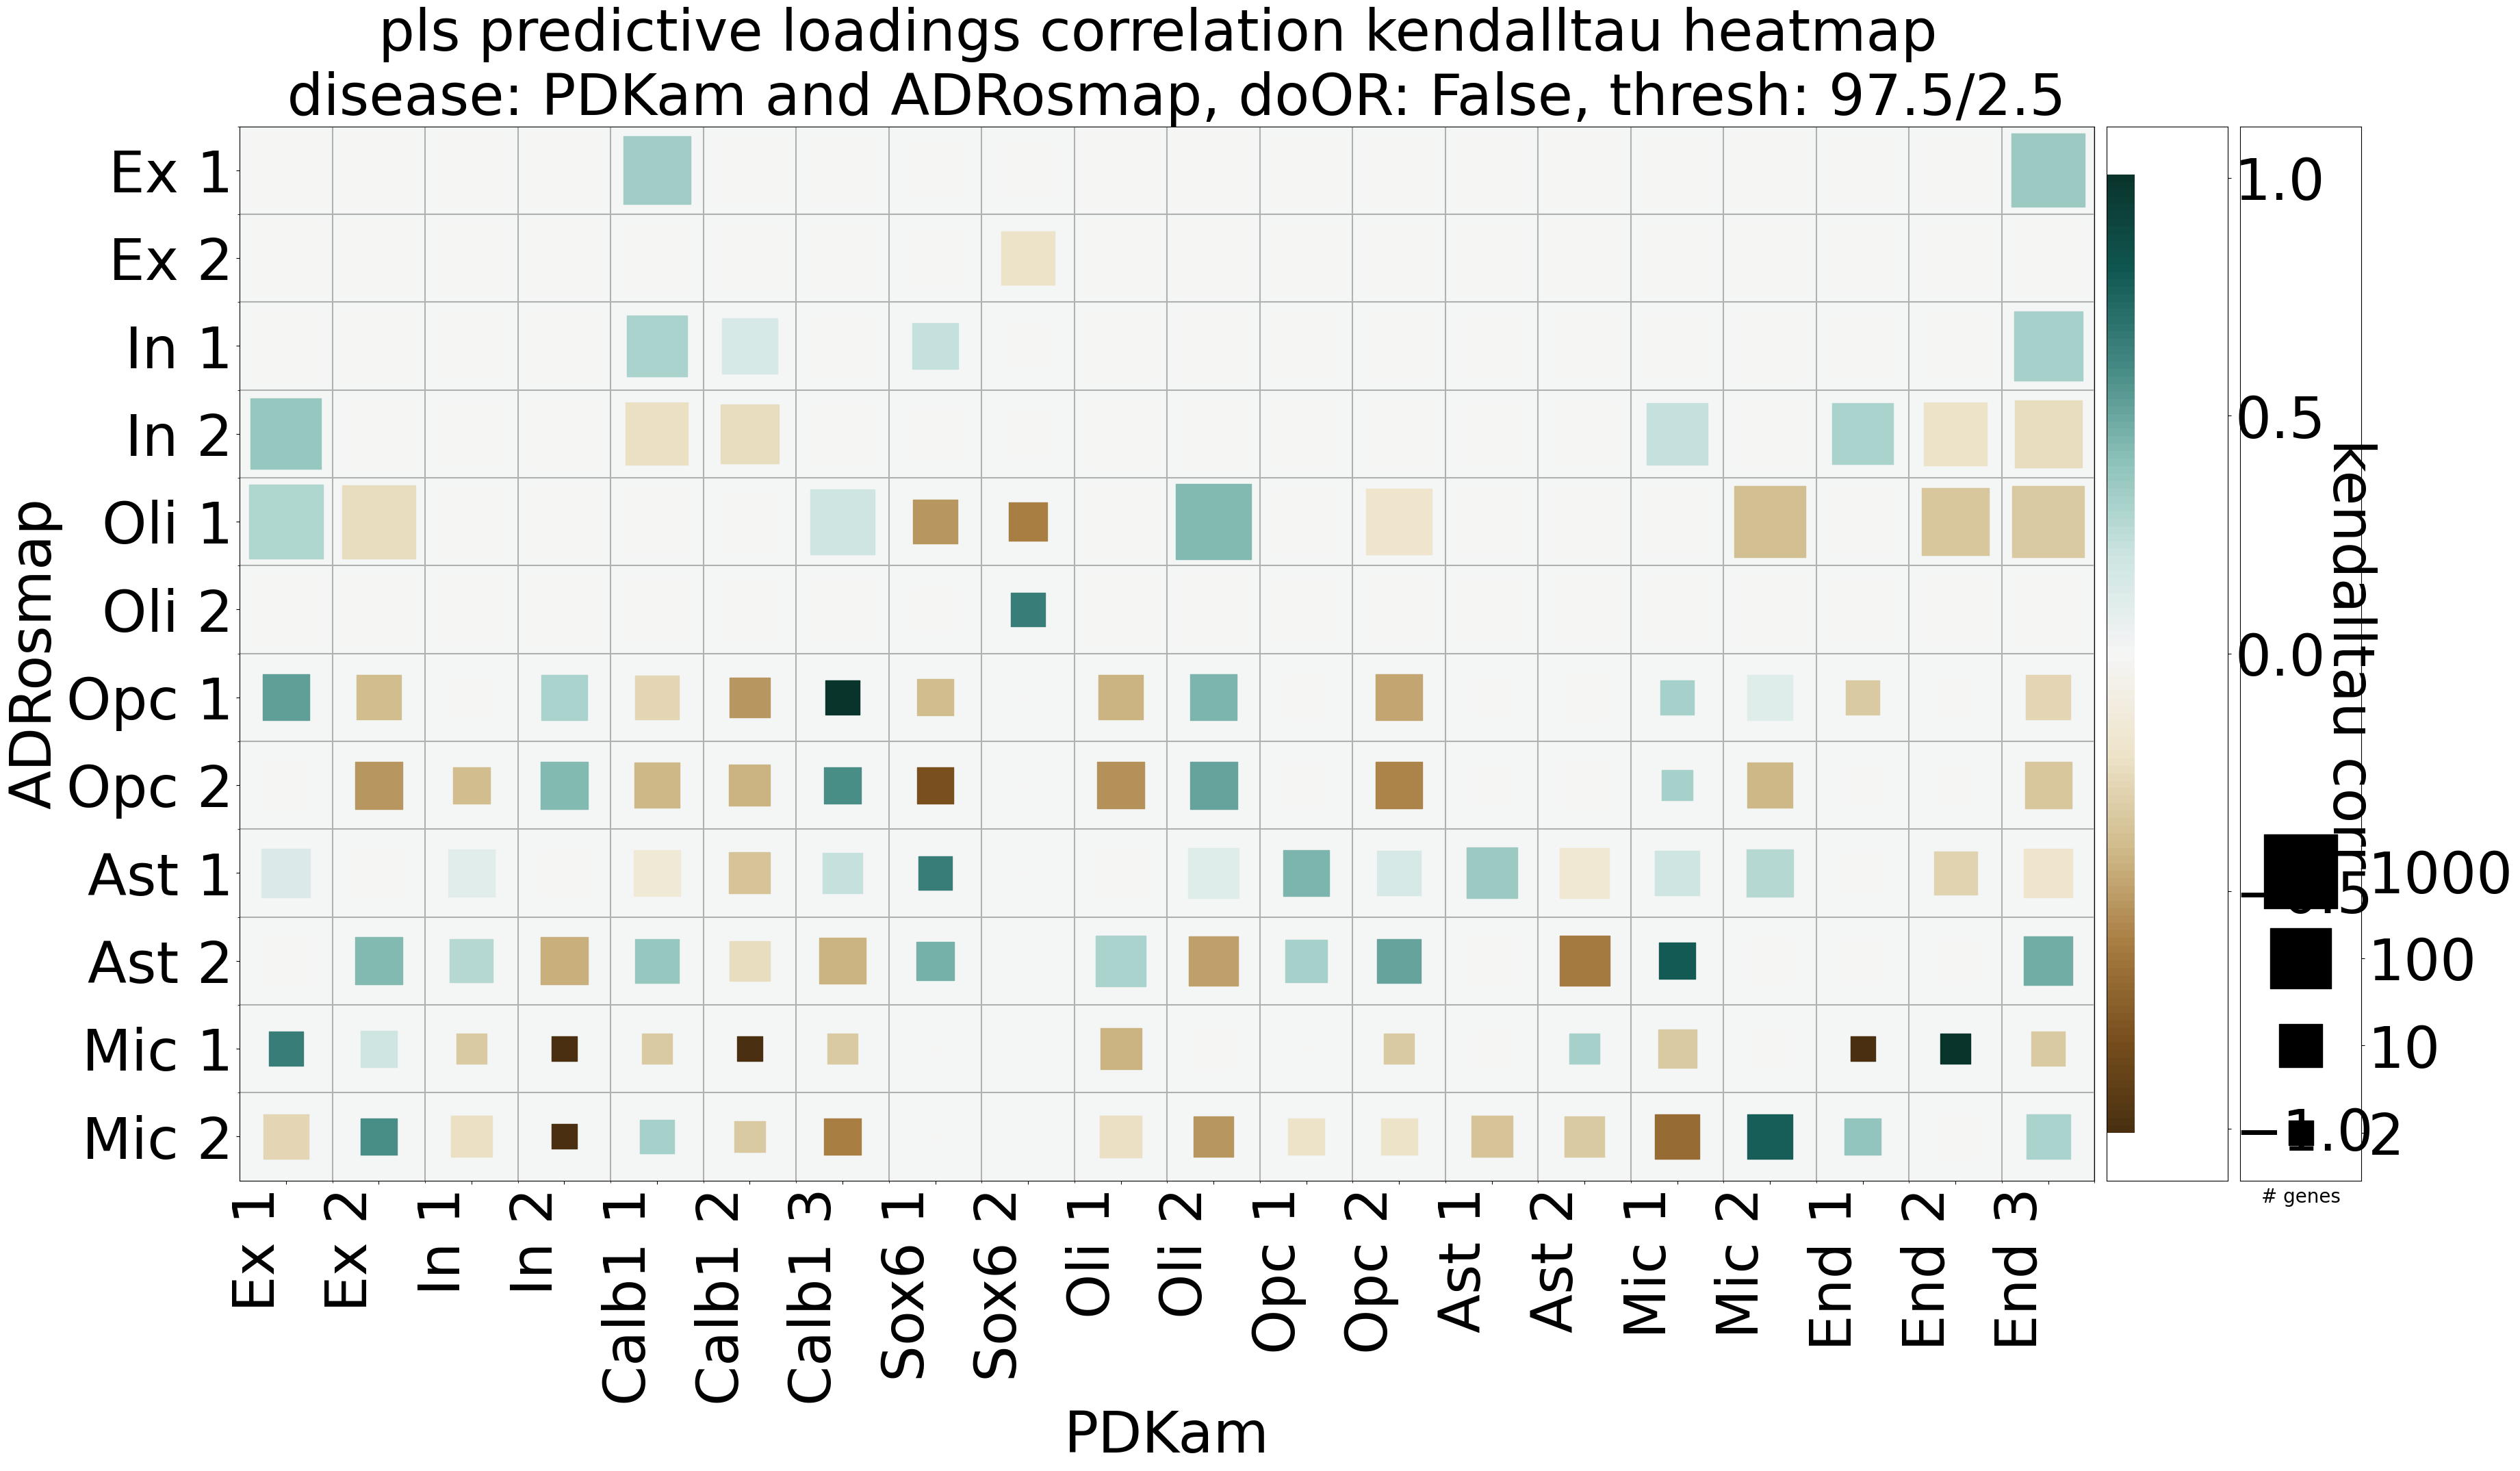

In [ ]:
doOR = False
corr_util = co.PLSCorrelationUtils(kendalltau, 'PD', 'AD', 'Kam', 'Rosmap', run.PATH_DIR, doOR = doOR, corr_colname = 'loading')
y_order = [ 'Ex 1', 'Ex 2', 'In 1', 'In 2','Oli 1', 'Oli 2', 'Opc 1', 'Opc 2', 'Ast 1', 'Ast 2', 'Mic 1', 'Mic 2', ]
x_order = ['Ex 1', 'Ex 2', 'In 1', 'In 2','Calb1 1', 'Calb1 2', 'Calb1 3', 'Sox6 1', 'Sox6 2',  'Oli 1', 'Oli 2', 'Opc 1', 'Opc 2', 'Ast 1', 'Ast 2', 'Mic 1', 'Mic 2',  'End 1', 'End 2', 'End 3']


f = corr_util.plot_corrs( size_scale = 8000, 
                         figsize=(40,20), 
                         fontsize=60, 
                         high_percentile=97.5, 
                         facecolor = facecolor, 
                         palette=palette, 
                         norm = (0,-1, 1), 
                         do_transpose=False, 
                         x_order = x_order, 
                         y_order = y_order, 
                         dropna = False,
                         size_labels = [2, 10,100,1000])

# GSEA

In [ ]:
fp = '/Users/anwesha/Library/CloudStorage/OneDrive-McGillUniversity/PHD/Research/NeuroOverlap/April_29/'

In [ ]:
celltype_map = {'ast': 'Ast', 'ex':'Ex', 'in': 'In', 'mic':'Mic', 'macro':'Macro', 'oligo':'Oli', 'opc':'Opc', \
            'endo':'End', 'per':'Per', 'sox6':'Sox6', 'calb1':'Calb1', 'epen':'Epen', 'l4_it':'L4_it', 'l5_it':'L5_it', 'vip':'Vip'}
def label_map(ct):
    for k,v in celltype_map.items():
        if k in ct.lower():
            return v
    return ct

In [ ]:
ad_d = 'Rosmap'
pd_d = 'Kam'

In [ ]:
corr_mtx = pd.read_csv(f'/Users/anwesha/Library/CloudStorage/OneDrive-McGillUniversity/PHD/Research/OverlapAnalysis_thor_pmi_adj/PD_AD/{pd_d}_{ad_d}/doOR_False/correlation_PD_AD_kendalltau_42seed_FalsedoOR.csv_1000thresholded_97.5highper_2.5lowper.csv')

In [ ]:
gsea_ad_dict = co.CorrelationBase.read_zip_to_dict(f'/Users/anwesha/Library/CloudStorage/OneDrive-McGillUniversity/PHD/Research/OverlapAnalysis_thor_pmi_adj/AD/{ad_d}/DEGenes/gsea_results_500bs_5thresh_42seed_97_5_highper_2_5lowper_labelpermutefactor.zip')
gsea_pd_dict = co.CorrelationBase.read_zip_to_dict(f'/Users/anwesha/Library/CloudStorage/OneDrive-McGillUniversity/PHD/Research/OverlapAnalysis_thor_pmi_adj/PD/{pd_d}/DEGenes/gsea_results_500bs_5thresh_42seed_97_5_highper_2_5lowper_labelpermutefactor.zip')

In [ ]:
loadings_ad = co.CorrelationBase.read_zip_to_dict('/Users/anwesha/Library/CloudStorage/OneDrive-McGillUniversity/PHD/Research/OverlapAnalysis_thor_pmi_adj/AD/Rosmap/DEGenes/pls_500bs_5thresh_42seed_thresholded_97_5highper_2_5lowper_labelpermutefactor.zip')
loadings_pd = co.CorrelationBase.read_zip_to_dict('/Users/anwesha/Library/CloudStorage/OneDrive-McGillUniversity/PHD/Research/OverlapAnalysis_thor_pmi_adj/PD/Kam/DEGenes/pls_500bs_5thresh_42seed_thresholded_97_5highper_2_5lowper_labelpermutefactor.zip')

In [ ]:
def get_robust_term(ser, plsdf):
    leading_genes = ser.Lead_genes.split(';')
    robust_genes = plsdf[(plsdf.component==ser.component) & (plsdf.loading!=0)].gene.values
    return len(set(leading_genes).intersection(robust_genes))
    

In [ ]:
gsea_ad_dict = co.CorrelationBase.read_zip_to_dict(gsea_ad_path)
gsea_ad = pd.DataFrame()
for k, df in gsea_ad_dict.items():
    if not df.empty:
        df['robust_genes'] = df.apply(get_robust_term, args = ([loadings_ad[k]]), axis=1)
        # df.drop(df[df.Term_robust==0].index, inplace=True)
        df['cell_type'] = k
        gsea_ad = pd.concat([df, gsea_ad])
    
del(gsea_ad_dict)
gsea_ad['gene_frac'] = gsea_ad[['Tag %', 'robust_genes']].apply(lambda x: x.robust_genes / int(x['Tag %'].split('/')[1]), axis=1)
gsea_ad.shape

(954, 15)

In [ ]:
gbp = gp.get_library(name='GO_Biological_Process_2023', organism='Human')

In [ ]:
gsea_pd = pd.DataFrame()
for k, df in gsea_pd_dict.items():
    if not df.empty:
        df['robust_genes'] = df.apply(get_robust_term, args = ([loadings_pd[k]]), axis=1)
        # df.drop(df[df.Term_robust==0].index, inplace=True)
        df['cell_type'] = k
        gsea_pd = pd.concat([df, gsea_pd])
    
gsea_pd.shape

(2813, 14)

In [ ]:
merged_gsea_df = gsea_ad.merge(gsea_pd, how = 'inner', on = ['Term'], suffixes = ['_ad', '_pd'])

In [ ]:
merged_gsea_df = merged_gsea_df[['cell_type_ad', 'cell_type_pd', 'component_ad', 'component_pd']].groupby(['cell_type_ad', 'cell_type_pd', 'component_ad', 'component_pd']).value_counts().to_frame('num_terms').reset_index()
merged_gsea_df[f'cell_comp_PD{pd_d}'] = merged_gsea_df['cell_type_pd'].astype(str) + '_' + merged_gsea_df['component_pd'].astype(int).astype(str)
merged_gsea_df[f'cell_comp_AD{ad_d}'] = merged_gsea_df['cell_type_ad'].astype(str) + '_' + merged_gsea_df['component_ad'].astype(str)

In [ ]:
corr_mtx = corr_mtx.merge(merged_gsea_df[['num_terms', f'cell_comp_PD{pd_d}', f'cell_comp_AD{ad_d}']], on = [f'cell_comp_PD{pd_d}', f'cell_comp_AD{ad_d}'], how='inner')

In [ ]:
corr_mtx[f'cell_comp_PD{pd_d}'] = corr_mtx[f'cell_comp_PD{pd_d}'].apply(lambda x: label_map(x.rsplit('_',1)[0])+' '+str(int(x.rsplit('_',1)[1])+1))
corr_mtx[f'cell_comp_AD{ad_d}'] = corr_mtx[f'cell_comp_AD{ad_d}'].apply(lambda x: label_map(x.rsplit('_',1)[0])+' '+str(int(x.rsplit('_',1)[1])+1))

In [ ]:
from sklearn.cluster import SpectralBiclustering, SpectralCoclustering

In [ ]:
data = corr_mtx.pivot_table(index=f'cell_comp_PD{pd_d}', columns=f'cell_comp_AD{ad_d}', values='num_terms').fillna(0)
rows = pd.DataFrame(data.index, columns=[f'cell_comp_PD{pd_d}'])
cols = pd.DataFrame(data.columns, columns=[f'cell_comp_AD{ad_d}'])

n_clusters = 2 # 3  # Sea 3
bicluster = SpectralBiclustering(n_clusters=n_clusters, random_state=42)
bicluster.fit(data.values)

# Rearranging the data to match the biclusters
fit_data = data.values[np.argsort(bicluster.row_labels_)]
fit_data = fit_data[:, np.argsort(bicluster.column_labels_)]


Text(0.5, 1.0, 'Visualizing term overlap and gene module correlation cross disease')

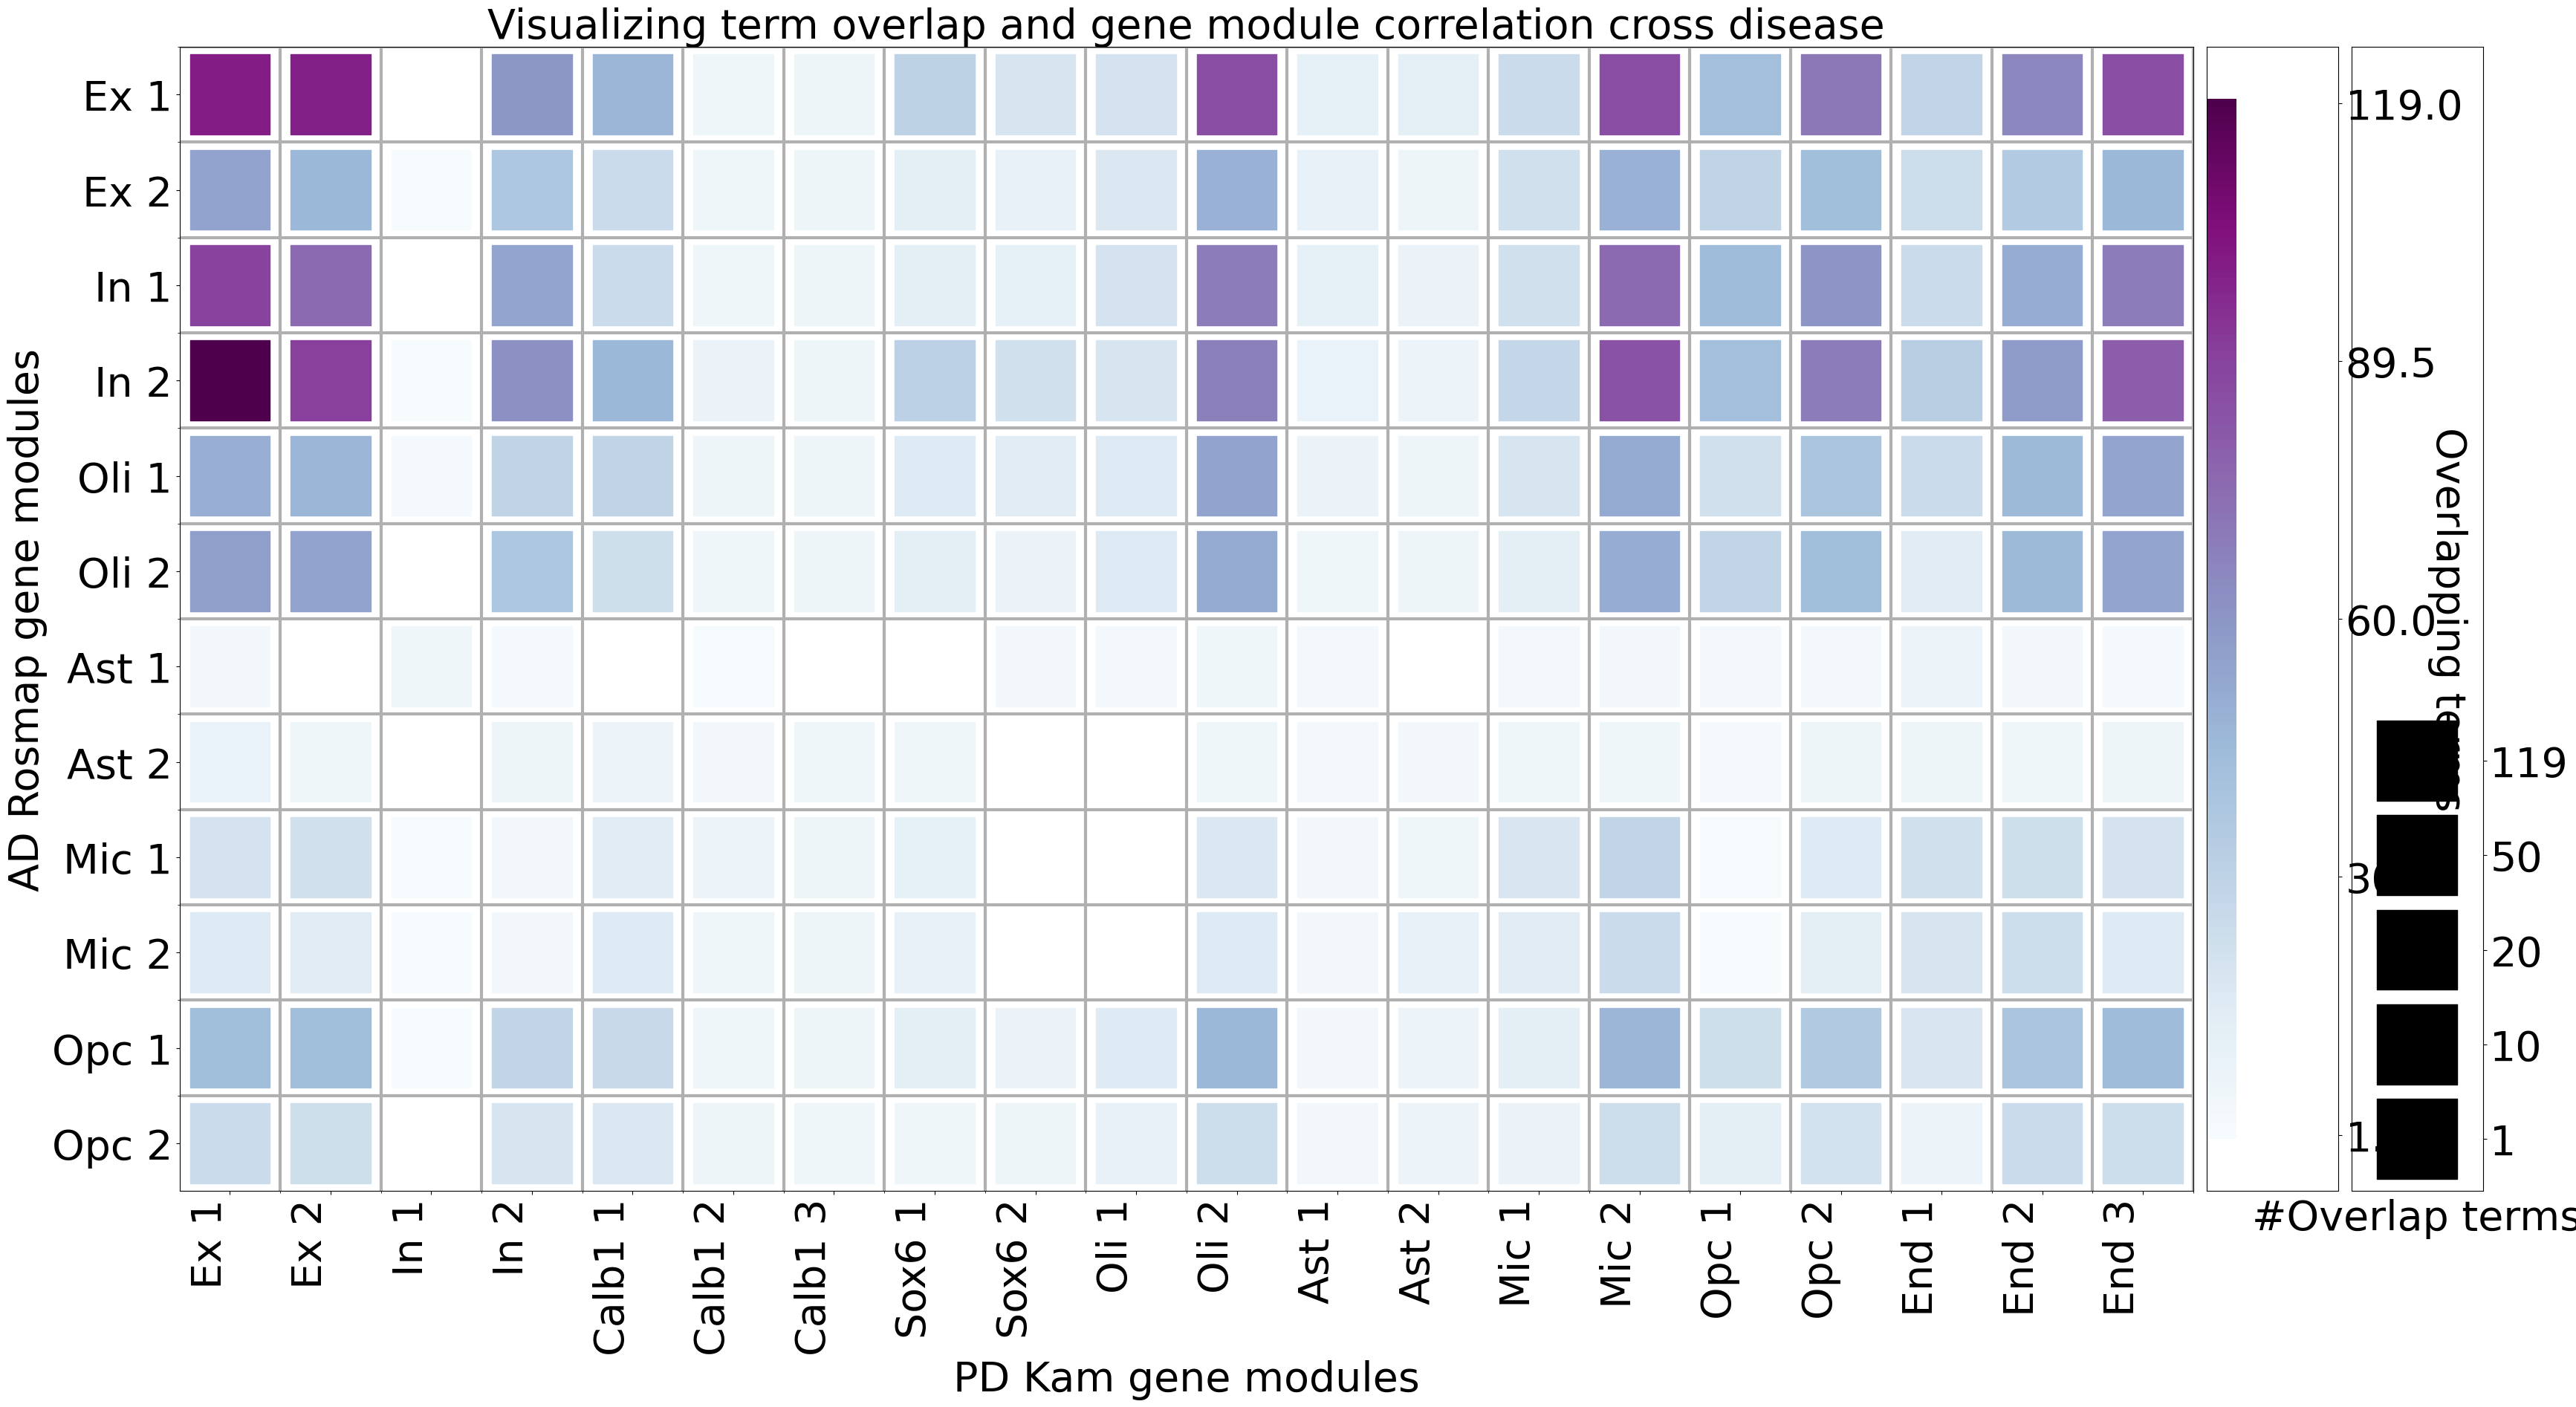

In [ ]:
f = plt.figure(figsize=(40, 20))
corr_mtx = corr_mtx.fillna(0)
size_labels = [1, 10, 20, 50, max(corr_mtx['num_terms'])]
num_size_label=len(size_labels) or 6
fontsize = 40

# CUSTOM BICLUSTERING + KEEPING GROUPS TOGETHER
x_order = ['Ex_1', 'Ex_2', 'Opc_1', 'Opc_2', 'Oli_1', 'Oli_2', 'Mic_1', 'Mic_2', 'End_1', 'End_2', 'End_3', 'In_1', 'In_2', 'Sox6_1', 'Sox6_2', 'Ast_1', 'Ast_2', 'Calb1_1', 'Calb1_2', 'Calb1_3',]
# x_order = np.squeeze(rows.values[np.argsort(bicluster.row_labels_)])
y_order = [  'Ex_1', 'Ex_2', 'In_1', 'In_2', 'Oli_1', 'Oli_2', 'Opc_1', 'Opc_2', 'Ast_1', 'Ast_2', 'Mic_1', 'Mic_2',]
# y_order = np.squeeze(cols.values[np.argsort(bicluster.column_labels_)])

# SAME AS PLS

x_order = ['Ex 1', 'Ex 2', 'In 1', 'In 2','Calb1 1', 'Calb1 2', 'Calb1 3', 'Sox6 1', 'Sox6 2',  'Oli 1', 'Oli 2',  'Ast 1', 'Ast 2', 'Mic 1', 'Mic 2', 'Opc 1', 'Opc 2', 'End 1', 'End 2', 'End 3']
y_order = [ 'Ex 1', 'Ex 2', 'In 1', 'In 2','Oli 1', 'Oli 2', 'Ast 1', 'Ast 2', 'Mic 1', 'Mic 2', 'Opc 1', 'Opc 2']


ax, ax1, ax2, ss = heatmap.heatmap(
      x = corr_mtx[f'cell_comp_PD{pd_d}'], # Column to use as horizontal dimension 
      y = corr_mtx[f'cell_comp_AD{ad_d}'], # Column to use as vertical dimension
      y_order = y_order[::-1], #np.squeeze(cols.values[np.argsort(bicluster.column_labels_)]), #[::-1],
      x_order = x_order, #np.squeeze(rows.values[np.argsort(bicluster.row_labels_)]), #[::-1], 
      size_scale = 6000, # Change this to see how it affects the plot
      # size = corr_mtx['num_terms'],
      # size_range = (np.log(1), np.log(10000)),
      color=corr_mtx['num_terms'].fillna(0), # Values to map to color, here we use number of items in each bucket
      color_range=(1,1,max(corr_mtx['num_terms'])),
      palette=sns.color_palette('BuPu', n_colors=128), #sns.dark_palette("#8E8BC1", n_colors=128), #sns.diverging_palette(140, 350, n=128, s=80, center="dark", sep=1), #sns.diverging_palette(140, 350, s=80, n=128, sep=10),
      fontsize = fontsize,
      x_tick_rotation = 90,
      # num_size_label=num_size_label,
      size_labels = size_labels,
      m_color='k',
      # y_order = corr_mtx[f'cell_comp_PD{pd_d}'].sort_values().unique()[::-1],
      # x_order = corr_mtx[f'cell_comp_AD{ad_d}'].sort_values().unique(),
      # size_labels = np.log(size_labels).tolist(),
      facecolor = 'white',
)

ax.grid(linewidth=3, which='minor')
ax1.set_ylabel('Overlapping terms', fontsize = fontsize, rotation=-90)
ax1.yaxis.set_label_position("right")
_ = ax2.set_yticklabels(np.array(ss).astype(int), rotation=0, fontsize = fontsize)
_ = ax2.set_xlabel('#Overlap terms', fontsize=fontsize)
ax2.patch.set_alpha(0)
for label in (ax1.get_xticklabels() + ax1.get_yticklabels()): label.set_fontsize(fontsize)

ax.set_xlabel(f'PD {pd_d} gene modules', fontsize = fontsize)
ax.set_ylabel(f'AD {ad_d} gene modules', fontsize = fontsize)
ax.set_title('Visualizing term overlap and gene module correlation cross disease', fontsize=fontsize)